
<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">EM Connectomics - Question 2</h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Monday, August 29, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


</div>



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p><b>Task 2:</b> This question looks at the mapping what fraction of synapses map to cells inhibitory or excitatory cells.
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1:</b> Import the key modules and set parameters

</div>

In [1]:
# Import modules

import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2022/em-connectomics"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/em-connectomics"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/em-connectomics-data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/em-connectomics"

from caveclient import CAVEclient

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib widget
    
# Initialize a client for the "minnie65_public_v343" datastack.
datastack_name = 'minnie65_public_v343'
client = CAVEclient(datastack_name)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Task 2.2: </b> How many nuclei are there per root_id?
        </div>


In [2]:
# list all the tables  avaliable
client.materialize.get_tables()
#client.materialize.get_table_metadata('nucleus_neuron_svm')

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

In [17]:
# get all the nuclei that are neurons
#client.materialize.get_table_metadata('nucleus_neuron_svm')
# use filter_equal_dict to filter neuron types 
nuclei_df= client.materialize.query_table('nucleus_neuron_svm',
                                         filter_equal_dict = {'cell_type' : 'neuron'})


# filter out all the entries where the pt_root_id is zero
nuclei_df= nuclei_df[nuclei_df.pt_root_id>0]


In [27]:
# Use pandas to make a new dataframe of how many times does a root id appears in the table.
# it should have two columns, root_ids/seg_ids and number_of_nuclei (call them what you want)
# each row is a rootID.
# Since each row is a nucleus, this effectively counts the number of neuronal somata.

nuclei_count_df = nuclei_df.groupby(by='pt_root_id')['pt_root_id'].count() #this will create 
# group this dataframe by pt_root_id and only display the pt_root_id  counts
nuclei_count_df.label = 'numer_of_nuclei'
nuclei_count_df = pd.DataFrame({'numer_of_nuclei':nuclei_count_df}).reset_index()
#reset the index to numeric values (0-n) and set pt_root_id to be a variable

nuclei_count_df

,pt_root_id,numer_of_nuclei
0,864691131800703080,1
1,864691131848667157,1
2,864691131906133483,1
3,864691131927301557,1
4,864691131956238489,1
...,...,...
76077,864691137197327937,3
76078,864691137197329217,1
76079,864691137197329985,1
76080,864691137197332033,1


(0.0, 8000.0)

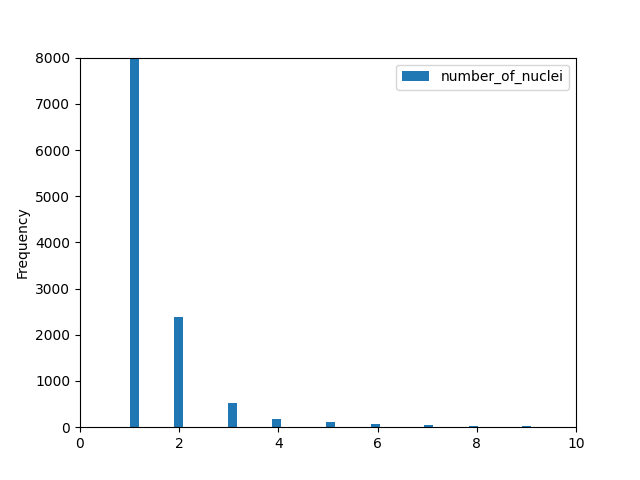

In [29]:
# make a histogram of the number of neuron nuclei per rootID
# use bins 0,1,2,3,4,5,6,7,8,9,10
nuclei_count_df["numer_of_nuclei"].hist()
ax = nuc_size_df.plot.hist(bins=1000)
ax.set_xlim (0,10)
ax.set_ylim (0,8000)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Task 2.3:</b> Pick a neuron with a clean or extended axon and get it's outputs
      </div>

In [56]:
clean_axon_df = client.materialize.query_table('proofreading_status_public_release',
                                             filter_out_dict={'status_axon':['non']})
neuronID = 864691136008567724
df_synapse = client.materialize.query_table('synapses_pni_2',
                                           filter_equal_dict={'pre_pt_root_id':neuronID},
                                           desired_resolution=(1000,1000,1000))

synapse_numNuc_df = pd.merge(df_synapse,nuc_size_df,left_on='post_pt_root_id',right_on = 'pt_root_id')
synapse_numNuc_df.shape 

(188, 11)

In [57]:
# merge the synapse table with your table of root_ids and how many nuclei they have
# to gather information about how many nuclei are associated with the post-synaptic segment
# feel free to drop all the rows that don't have entries in the nucleus table for now

synapse_singleNuc_df = synapse_numNuc_df[synapse_numNuc_df.number_of_nuclei == 1]
synapse_singleNuc_df = synapse_singleNuc_df.dropna()
#now 'synapse_singleNuc_df' contains only cells with 1 nucleus and no nans


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b> Task 2.3: </b> Which of the synapses from this cell map to IDs which have just one neuron nucleus?
        </div>


In [68]:
# use the cell type prediction table to get a list of predictions about cell types
#get all the soma predictions
df_soma_predit = client.materialize.query_table('aibs_soma_nuc_metamodel_preds_v117')

# for the single nucleus synapses, merge in the cell type predictions.
# use 'left'/'right' join to keep a row for every synapse
df_syn_cellType_nuc = pd.merge(synapse_singleNuc_df,df_soma_predit,
         left_on = 'post_pt_root_id',
         right_on= 'pt_root_id',
         how='left')


In [70]:
# check to make sure you only have 1 row per synapseID afterwards
df_syn_cellType_nuc.id_x.value_counts().sort_values(ascending=False)
# or 
df_syn_cellType_nuc.id_x.unique().shape == df_syn_cellType_nuc.id_x.shape

True

Text(0.5, 1.0, 'cell type target distribution of BPC 864691136008567724')

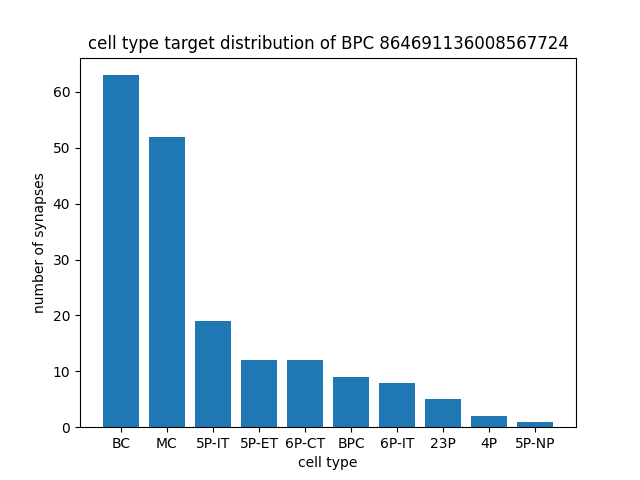

In [76]:
# Make a histogram of how this cell distributes it's synapses over cell types
figure, ax = plt.subplots()
cell_type_counts = df_syn_cellType_nuc.cell_type.value_counts()
ax.bar(cell_type_counts.index, cell_type_counts) #use bar graph to plot value counts 
ax.set_xlabel('cell type')
ax.set_ylabel('number of synapses')
ax.set_title(f'cell type target distribution of BPC {neuronID}')


In [94]:
# how many synapses do you not know what cell type is on the post-synaptic side?
unknown_cell = df_syn_cellType_nuc[df_syn_cellType_nuc.cell_type.isna()]

print(f'no cell type: {len(unknown_cell)}')

      

no cell type: 1
